# **CNN Using Barebones Data Improvement**

Barebones means i just took the raw data, converted it into spectrograms, then fed it into CNN. 
I used scaling (stretching and shrinking) to ensure that they all have the same number of features
- Initially I used 128x128

## **Improvement-1**
I noticed that the volumes of the samples where very different. 
* I will try first normalizing the volume of all samples between 0 and 1. 
* Then i will convert those to mel spectrograms, and then normalize those between 0 and 1 also between sample

I noticed that the lengths are very different so scaling it by stretching and shrinking the data basically gave the machine nonsense and thats why the accuracy was bad. 

I can try using audio samples that are greater than 2 seconds long, and use a 2 second window and a 1 second overlap to create the spectrograms with each sample, keeping track of the class of the audio sample. This should make all the spectrograms have the same size and surely improve the results a bit. 

# **Steps to improve the model**
1. Filter Short Audio Samples: Discard any audio samples that are shorter than 2 seconds. Ensures all samples have sufficient length for feature extraction

2. Adding sliding window with overlap: 2s window with 1s overlap for consistent spectrograms for all audio files

3. Normalise audio and spectrograms: Normalise both the raw data and mel spectrograms to a 0-1 range. Helps the model generalise better with varying amplitude

# **Improvement-2**

The validation accuracy in the previous improvement was around 67%, which is good, but not good enough. In this notebook, i will try to improve on this and note what i do as i go along. 

Thoughts:
- Improve the mel spectrograms (Adjusting the window size and overlap to capture more content)
- Increase the number of mel bands from 128 to 256 to capture more frequency information

- I could improve the CNN model by adding more layers
- Adding regularization and increase the drop out rate to reduce overfitting (maybe add an L2 reg)

- Stuff on the learning rate or maybe the optimize

# ***Libraries***

In [19]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa
import scipy.ndimage
import IPython.display as ipd

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1


# Model
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers


# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
train_path = 'C:/Users/thato/Documents/Final-Year-Project/Project-V1/train_val_7.csv'
df = pd.read_csv(train_path)

npy_filenames = df['filename_npy'].values
labels = df['primary_label'].values

npy_path = 'C:/Users/thato/OneDrive - University of Cape Town/Bird Classification Project/AudioSamples/birdclef-2023/train_audio_npy/'

In [4]:
df.head()

,primary_label,type,rating,filename,duration,filename_npy,set
0,fotdro5,call,4.0,fotdro5/XC412171.ogg,58.09600,fotdro5/XC412171.npy,tr
1,fotdro5,call,5.0,fotdro5/XC606054.ogg,20.81900,fotdro5/XC606054.npy,tr
2,fotdro5,song,3.0,fotdro5/XC633730.ogg,30.40800,fotdro5/XC633730.npy,tr
3,fotdro5,both,3.0,fotdro5/XC195990.ogg,31.13800,fotdro5/XC195990.npy,tr
4,fotdro5,call,4.5,fotdro5/XC613619.ogg,16.69225,fotdro5/XC613619.npy,tr


## Taking out training and validation

In [5]:
train_indices = df[df['set'] == 'tr'].index
val_indices = df[df['set'] == 'val'].index

train_files = npy_filenames[train_indices]
train_labels = labels[train_indices]

val_files = npy_filenames[val_indices]
val_labels = labels[val_indices]

## Encoding the labels

In [6]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

In [7]:
sr = 16000

# ***Functions to get the windowed spectrograms***
- have normalization

In [8]:
# Function to normalize audio data between 0 and 1
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))


In [9]:
# Function to generate mel spectrogram with sliding window and overlap
def get_mel_spectrogram_with_window(npy_file, sr=sr, n_mels=128, hop_length=512, window_size=2, overlap=1, target_shape=(128, 128)):
    audio_data = np.load(npy_path + npy_file)
    audio_duration = librosa.get_duration(y=audio_data, sr=sr)
    if audio_duration < window_size:
        return None  # Skip this sample and remove short samples
    
    audio_data = normalize_audio(audio_data)
    
    # Define the step based on the window and overlap (in samples, not time)
    step = int(window_size * sr)
    overlap_step = int(overlap * sr)
    
    mel_spectrograms = []
    
    # Create multiple windows with overlap
    for start in range(0, len(audio_data) - step + 1, overlap_step):
        windowed_data = audio_data[start:start + step]
        
        mel_spectrogram = librosa.feature.melspectrogram(y=windowed_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        mel_spectrogram_db = (mel_spectrogram_db - mel_spectrogram_db.min()) / (mel_spectrogram_db.max() - mel_spectrogram_db.min())
        
        # Resize the mel spectrogram to 128x128
        mel_spectrogram_resized = scipy.ndimage.zoom(mel_spectrogram_db, (target_shape[0] / mel_spectrogram_db.shape[0], 
                                                                          target_shape[1] / mel_spectrogram_db.shape[1]))
        mel_spectrograms.append(mel_spectrogram_resized)
    
    return mel_spectrograms  # Returns a list of 128x128 mel spectrograms

### Viewing audio snippet and matching plot
So I want to section a single audio snippet, and view the segmented spectrogram to ensure it matches with the audio

In [10]:
def play_and_plot_window(npy_file, window_idx, sr=22050, n_mels=128, hop_length=512, window_size=2, overlap=1, target_shape=(128, 128)):
   
    audio_data = np.load(npy_path + npy_file)
    audio_data = normalize_audio(audio_data)
    
    # Get the duration of the audio and make sure it's long enough
    audio_duration = librosa.get_duration(y=audio_data, sr=sr)
    if audio_duration < window_size:
        print("Audio too short for the specified window size.")
        return None
    
    # Calculate step size and overlap in samples
    step = int(window_size * sr)
    overlap_step = int(overlap * sr)
    
    # Get start and end points of the chosen window
    start = window_idx * overlap_step
    end = start + step
    
    if end > len(audio_data):
        print(f"Window index {window_idx} exceeds audio length.")
        return None
    
    # Extract the windowed audio
    windowed_audio = audio_data[start:end]
    
    # Generate the mel spectrogram for the selected window
    mel_spectrogram = librosa.feature.melspectrogram(y=windowed_audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Normalize the spectrogram
    mel_spectrogram_db = (mel_spectrogram_db - mel_spectrogram_db.min()) / (mel_spectrogram_db.max() - mel_spectrogram_db.min())
    
    # Resize to target shape (128x128)
    mel_spectrogram_resized = scipy.ndimage.zoom(mel_spectrogram_db, (target_shape[0] / mel_spectrogram_db.shape[0], 
                                                                      target_shape[1] / mel_spectrogram_db.shape[1]))
    
    # Play the audio for the window
    print(f"Playing audio window {window_idx} from {start/sr:.2f}s to {end/sr:.2f}s:")
    ipd.display(ipd.Audio(windowed_audio, rate=sr))
    
    # Plot the mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_resized, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram for Window {window_idx}')
    plt.show()

Playing audio window 1 from 1.00s to 3.00s:


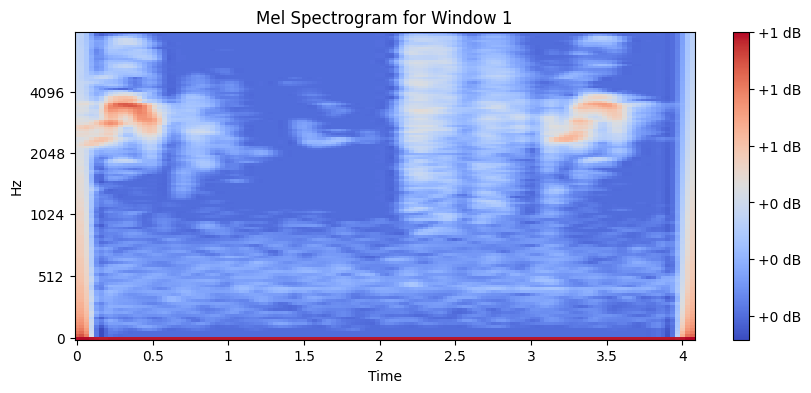

In [11]:
example_npy = npy_filenames[12]
play_and_plot_window(example_npy, window_idx=1, sr=sr, window_size=2, overlap=1)

# Preparing Data for CNN

### **Generate windowed mel spectrograms and match them with labels**

In [12]:
def prepare_data_for_model(npy_files, labels_encoded, sr=sr, window_size=2, overlap=1, target_shape=(128, 128)):
    mel_spectrograms = []
    mel_labels = []

    for npy_file, label in tqdm(zip(npy_files, labels_encoded), desc="Processing files"):
        mel_specs = get_mel_spectrogram_with_window(npy_file, sr=sr, window_size=window_size, overlap=overlap, target_shape=target_shape)
        if mel_specs is None:
            continue  # Skip short files
        
        for mel_spec in mel_specs:
            mel_spec = np.expand_dims(mel_spec, axis=-1)  # Add a channel dimension for CNN
            mel_spectrograms.append(mel_spec)
            mel_labels.append(label)
    
    mel_spectrograms = np.array(mel_spectrograms)
    mel_labels = np.array(mel_labels)
    
    # Shuffle the data to ensure good mixing
    indices = np.random.permutation(len(mel_spectrograms))
    mel_spectrograms = mel_spectrograms[indices]
    mel_labels = mel_labels[indices]
    
    return mel_spectrograms, mel_labels

### **Prepare data for training and val**

In [13]:
# Prepare training data
X_train, y_train = prepare_data_for_model(train_files, train_labels_encoded, sr=sr, window_size=2, overlap=1, target_shape=(128, 128))

# Prepare validation data
X_val, y_val = prepare_data_for_model(val_files, val_labels_encoded, sr=sr, window_size=2, overlap=1, target_shape=(128, 128))


Processing files: 427it [02:21,  3.01it/s]
Processing files: 252it [01:16,  3.30it/s]


### ***Set up CNN Model***

In [20]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Add more convolutional layers with regularization
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1), kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Use a lower learning rate or add a learning rate scheduler
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

### Initialize and train the model

In [21]:
# Set input shape (128, 128, 1) and number of output classes
input_shape = (128, 128, 1)
num_classes = len(np.unique(train_labels_encoded))

# Create CNN model
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)

c:\Users\thato\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 891s 1s/step - accuracy: 0.4807 - loss: 2.5341 - val_accuracy: 0.2844 - val_loss: 6.1954
Epoch 2/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 894s 1s/step - accuracy: 0.6278 - loss: 1.7350 - val_accuracy: 0.4138 - val_loss: 4.7120
Epoch 3/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 894s 1s/step - accuracy: 0.7041 - loss: 1.4924 - val_accuracy: 0.4814 - val_loss: 4.1956
Epoch 4/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 897s 1s/step - accuracy: 0.7619 - loss: 1.3075 - val_accuracy: 0.5462 - val_loss: 3.5167
Epoch 5/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 957s 1s/step - accuracy: 0.7997 - loss: 1.1705 - val_accuracy: 0.5927 - val_loss: 2.9507
Epoch 6/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 911s 1s/step - accuracy: 0.8355 - loss: 1.0433 - val_accuracy: 0.5645 - val_loss: 3.1790
Epoch 7/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 902s 1s/step - accuracy: 0.8544 - loss: 0.9400 - val_accuracy: 0.6493 - val_loss: 2.5246
Epoch 8/10
709/709 ━━━━━━━━━━━━━━━━━━━━ 904s 1s/step - accuracy: 0.8668 - loss: 0.8837 - val_accu

In [23]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy}")


413/413 ━━━━━━━━━━━━━━━━━━━━ 77s 186ms/step - accuracy: 0.6679 - loss: 2.5811
Validation Accuracy: 0.6700273156166077


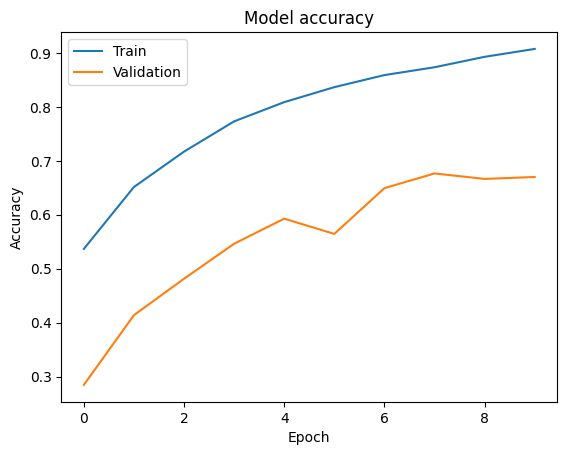

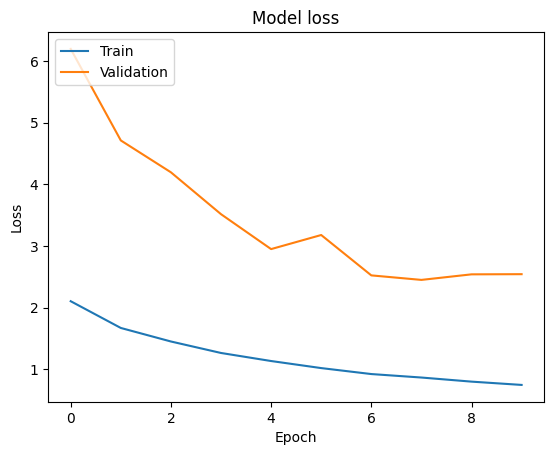

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()